In [3]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import matplotlib.pyplot as plt


# Figure size fonts for latex:
title_size = 44
axis_size = 42
legend_size = 40

# Regular font size:
title_size = 24
axis_size = 22
legend_size = 20

In [58]:
# Functions to model a DP draw and build a sample distribution out of G.
def dp_draw_univariate(alpha, base_function, k_trunc):
    beta_dist = stats.beta(a=1, b=alpha)
    total_prob = 1.
    remain_prob = total_prob
    dp_sample = list()
    
    while k_trunc != len(dp_sample):
        sample_pi = beta_dist.rvs(1)[0]
        pi_i = sample_pi*remain_prob
        sample_theta = base_function.rvs(1)[0]
        dp_sample.append([pi_i, sample_theta])
        remain_prob *= (1-sample_pi)
        
    return np.array(dp_sample, dtype=np.float64)

base_function = stats.norm(loc=0., scale=3)
base_function.rvs(1)[0]
dp_draw_univariate(alpha=2, base_function=base_function, k_trunc = 10)


array([[ 5.18337492e-02, -3.29963764e+00],
       [ 5.81245086e-01, -1.93093193e+00],
       [ 2.66670713e-01,  3.23436982e+00],
       [ 4.43761213e-02,  5.96950821e+00],
       [ 2.77677924e-02, -1.03903180e+00],
       [ 2.79671112e-03, -4.13668661e+00],
       [ 1.03957021e-02,  5.26088404e+00],
       [ 3.27373093e-03,  2.30981969e+00],
       [ 3.09226147e-03, -3.24758529e+00],
       [ 6.29644380e-04,  5.17508851e-01]])

In [160]:
# Functions to model a DP draw and build a sample distribution out of G.
def dp_draw(alpha, base_function, k_trunc):
    beta_dist = stats.beta(a=1, b=alpha)
    total_prob = 1.
    remain_prob = total_prob
    dp_sample = list()
    
    while k_trunc != len(dp_sample):
        sample_pi = beta_dist.rvs(1)[0]
        pi_i = sample_pi*remain_prob
#         sample_theta = base_function.rvs(1)[0]
        sample_theta = [item for item in base_function.rvs(1)]
#         print('sample_theta: ', sample_theta)
#         dp_sample.append([pi_i, sample_theta])
        dp_sample.append([pi_i] + sample_theta)
        remain_prob *= (1-sample_pi)
        
#     return np.array(dp_sample, dtype=np.float64)
    return np.array(dp_sample, dtype=np.float64)

dp_draw(alpha=2, base_function=multinorm_base, k_trunc = 10)

array([[ 5.03406606e-01,  1.22506706e+00, -3.10352526e-01],
       [ 2.81081129e-01, -8.15853328e-01, -8.64750593e-01],
       [ 5.34686233e-02, -2.39540706e-01, -1.41103010e-01],
       [ 9.75268323e-02,  1.77081018e+00, -4.15465199e-02],
       [ 1.97583380e-03, -8.45251700e-01, -1.70656902e+00],
       [ 3.78726376e-02, -5.09659678e-01, -1.38624257e+00],
       [ 1.33202035e-02,  7.96278380e-02, -4.53015598e-01],
       [ 5.86243578e-03,  3.69948607e+00,  8.06792613e-01],
       [ 1.03155095e-03,  2.30664157e+00, -5.95167740e-01],
       [ 2.42260460e-03,  1.04988500e+00, -2.09173632e-01]])

In [161]:
def dirichlet_process(alpha, base_function, k_trunc, num_samples, dim):
    dp_samples = np.zeros((num_samples, k_trunc, dim +1 ))
    for i in range(0, num_samples):
        sample = dp_draw(alpha=alpha, base_function=base_function, k_trunc=k_trunc)
        dp_samples[i, :, : ] = sample
        print('Processed samples: %s/%s' % (i+1, num_samples))
        clear_output(wait=True)
    print('DP Constructed:')
    print('\t Number of samples: %s' % dp_samples.shape[0])
    print('\t Alpha: %s' % alpha)
    print('\t Truncation value: %s' % dp_samples.shape[1])
    print('\t Bease measure: %s' % base_function)
    return dp_samples

dirichlet_process(alpha=2, base_function=multinorm_base, k_trunc = 10, 
                  num_samples = 20, dim = 2)

DP Constructed:
	 Number of samples: 20
	 Alpha: 2
	 Truncation value: 10
	 Bease measure: <scipy.stats._multivariate.multivariate_normal_frozen object at 0x1a16d74898>


array([[[ 5.00504485e-01, -2.12787573e-01,  2.39359653e-01],
        [ 2.93383786e-01,  1.58946367e+00, -1.08777774e+00],
        [ 1.04245469e-01,  9.81399164e-01, -4.69543689e-01],
        [ 3.91809687e-02,  2.36983094e+00,  9.99681718e-01],
        [ 4.24877512e-02,  3.36745504e+00, -8.93112747e-02],
        [ 2.50515925e-03,  9.40429852e-01,  8.09773758e-01],
        [ 4.81663048e-04,  5.31971246e-01, -4.91915671e-01],
        [ 9.16022788e-03, -3.56270489e+00, -7.05011618e-01],
        [ 1.74743700e-04, -2.03476076e-01, -5.15857949e-01],
        [ 3.55828405e-03,  5.04198299e-01,  5.58905958e-02]],

       [[ 2.86639611e-01,  2.19384043e+00, -1.04381702e+00],
        [ 3.83350980e-01,  3.52263657e+00,  1.37650206e+00],
        [ 2.90471239e-01, -2.78741996e-02,  5.93250706e-01],
        [ 5.70476759e-03,  2.09447862e+00,  6.07795458e-02],
        [ 1.68445705e-02,  1.93692543e+00, -9.82902835e-01],
        [ 9.18441491e-03, -1.31790519e-01, -1.49348078e+00],
        [ 3.89763357e-

In [121]:
# Functions to model a DP draw and build a sample distribution out of G.
# Note! base_function is now a matrix of size (k_trunc, 2)
def hdp_draw_univariate(alpha, base_function, k_trunc):
    beta_dist = stats.beta(a=1, b=alpha)
    total_prob = 1.
    remain_prob = total_prob
    hdp_sample = list()
    while k_trunc != len(hdp_sample):
        sample_pi = beta_dist.rvs(1)[0]
        pi_i = sample_pi*remain_prob
        
        sample_theta = np.random.choice(base_function[:, 1], 1,
              p=base_function[:, 0])
        
        hdp_sample.append([pi_i, sample_theta])
        remain_prob *= (1-sample_pi)
    return np.array(hdp_sample, dtype=np.float64)

num_samples = 1
dp_samples = dirichlet_process(alpha=2, base_function=base_function, 
                               k_trunc=10, num_samples=num_samples, dim=1)
G_0 = dp_samples[0, :, :]
G_0[:,0] /= np.sum(G_0[:,0])

hdp_draw_univariate(alpha=2, base_function=G_0, k_trunc=10)

DP Constructed:
	 Number of samples: 1
	 Alpha: 2
	 Truncation value: 10
	 Bease measure: <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a16d54da0>


array([[ 0.17049707, -1.2469145 ],
       [ 0.29926659,  1.08717573],
       [ 0.11262691,  4.40041132],
       [ 0.22860346, -3.03296574],
       [ 0.01036083,  1.08717573],
       [ 0.05195164,  1.08717573],
       [ 0.02009402,  4.40041132],
       [ 0.03856087, -1.2469145 ],
       [ 0.01630555,  1.08717573],
       [ 0.00781711, -1.2469145 ]])

In [183]:
# Functions to model a DP draw and build a sample distribution out of G.
# Note! base_function is now a matrix of size (k_trunc, 2)
def hdp_draw(alpha, base_function, k_trunc):
    beta_dist = stats.beta(a=1, b=alpha)
    total_prob = 1.
    remain_prob = total_prob
    hdp_sample = list()
    while k_trunc != len(hdp_sample):
        sample_pi = beta_dist.rvs(1)[0]
        pi_i = sample_pi*remain_prob
        
        sample_theta_ind = np.random.choice([i for i in range(len(base_function))], 1,
              p=base_function[:, 0])
        sample_theta = base_function[sample_theta_ind, 1:]
#         print('sample theta', sample_theta[0])
#         print('pi: ', [pi_i])
        hdp_list = np.zeros(1+len(sample_theta[0]))
        hdp_list[0] = pi_i
        for i in range(len(sample_theta[0])):
            hdp_list[i+1] = sample_theta[0][i]
        hdp_sample.append(hdp_list)
#         print(hdp_sample)
        remain_prob *= (1-sample_pi)
        
    return np.array(hdp_sample, dtype=np.float64)


## Test
num_samples = 1
dp_samples = dirichlet_process(alpha=2, base_function=multinorm_base, k_trunc = 10, 
                  num_samples = num_samples, dim = 3)


G_0 = dp_samples[0, :, :]
G_0[:,0] /= np.sum(G_0[:,0])


hdp_draw(alpha=2, base_function=G_0, k_trunc=10)

DP Constructed:
	 Number of samples: 1
	 Alpha: 2
	 Truncation value: 10
	 Bease measure: <scipy.stats._multivariate.multivariate_normal_frozen object at 0x1a16d54e10>


array([[ 0.33896562, -1.0426949 ,  0.12555034,  1.56896651],
       [ 0.02550803, -0.33954022, -0.43603916,  0.52310505],
       [ 0.24131354,  1.57142056,  0.53071956,  1.2308993 ],
       [ 0.12356911, -0.33954022, -0.43603916,  0.52310505],
       [ 0.0376184 ,  1.57142056,  0.53071956,  1.2308993 ],
       [ 0.01486318, -1.0426949 ,  0.12555034,  1.56896651],
       [ 0.15561656, -1.0426949 ,  0.12555034,  1.56896651],
       [ 0.00517101, -1.27566086,  0.07814661,  1.34169281],
       [ 0.03564139, -0.33954022, -0.43603916,  0.52310505],
       [ 0.00859548, -0.33954022, -0.43603916,  0.52310505]])

In [178]:
def hierarchical_dirichlet_process(alpha, base_function, k_trunc, num_samples, dim):
    hdp_samples = np.zeros((num_samples, k_trunc, dim+1))
    for i in range(0, num_samples):
        sample = hdp_draw(alpha=alpha, base_function=base_function, k_trunc=k_trunc)
        hdp_samples[i, :, : ] = sample
        print('Processed samples: %s/%s' % (i+1, num_samples))
        clear_output(wait=True)
    print('DP Constructed:')
    print('\t Number of samples: %s' % hdp_samples.shape[0])
    print('\t Alpha: %s' % alpha)
    print('\t Truncation value: %s' % hdp_samples.shape[1])
    print('\t Bease measure: %s' % base_function)
    return hdp_samples

hierarchical_dirichlet_process(alpha=2, base_function=G_0, k_trunc=10, num_samples=2, dim=2)

DP Constructed:
	 Number of samples: 2
	 Alpha: 2
	 Truncation value: 10
	 Bease measure: [[ 2.21517278e-01 -1.44865601e+00 -6.34736787e-01]
 [ 3.68696315e-01 -6.53653516e-01 -6.86865592e-01]
 [ 1.39960479e-04  1.52218432e-01 -5.64888342e-01]
 [ 1.16682847e-01  5.41585369e-01 -5.87495845e-02]
 [ 2.33545753e-01  6.66858528e-01 -1.40250589e+00]
 [ 1.23890371e-02 -1.37214188e+00 -1.64825752e-01]
 [ 3.94490846e-02  1.23534963e-02  2.44882670e-01]
 [ 5.70807891e-04 -3.66791549e-01 -1.98264211e-01]
 [ 5.71891632e-03  4.85235483e-01 -6.66190837e-01]
 [ 1.29000020e-03 -1.34846611e+00 -3.66641924e-01]]


array([[[ 2.32432015e-01, -6.53653516e-01, -6.86865592e-01],
        [ 9.44703522e-02, -1.44865601e+00, -6.34736787e-01],
        [ 1.42096737e-01, -6.53653516e-01, -6.86865592e-01],
        [ 1.24609724e-02,  6.66858528e-01, -1.40250589e+00],
        [ 2.63992727e-01,  6.66858528e-01, -1.40250589e+00],
        [ 1.03458925e-01, -1.44865601e+00, -6.34736787e-01],
        [ 2.94415658e-02,  6.66858528e-01, -1.40250589e+00],
        [ 3.02806810e-02, -6.53653516e-01, -6.86865592e-01],
        [ 1.53533043e-02,  6.66858528e-01, -1.40250589e+00],
        [ 2.87225920e-02, -6.53653516e-01, -6.86865592e-01]],

       [[ 1.74787874e-02, -1.44865601e+00, -6.34736787e-01],
        [ 9.29275145e-01,  5.41585369e-01, -5.87495845e-02],
        [ 2.09773402e-02, -6.53653516e-01, -6.86865592e-01],
        [ 2.76689620e-03, -1.44865601e+00, -6.34736787e-01],
        [ 1.81523654e-02, -1.44865601e+00, -6.34736787e-01],
        [ 6.35206539e-05, -6.53653516e-01, -6.86865592e-01],
        [ 2.26513007e-

In [153]:
base_function = stats.norm(loc=0., scale=3)
base_function.rvs(1)[0]

array([-1.73461589, -0.98965056])

In [157]:
multinorm_base = stats.multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])
multinorm_base.rvs(1)

num_samples = 1
# base_function = stats.norm(loc=0., scale=3)
base_function = multinorm_base

dp_dict = dict()

# Keeping the same k_trunc for all DP samples, I do so to keep a closer approximation on the DP Draw plot, for the DP visualization over a finite set, we can use a lower 
# tructation number for the lower alphas since the dirichlet vector pi get closer to one with the first dimensions.

k_trunc = 100

alpha = 1000
dp_large_alpha = dirichlet_process(alpha, base_function, k_trunc, num_samples, dim=2)
dp_dict[alpha] = dp_large_alpha

alpha = 100
dp_medium_alpha = dirichlet_process(alpha, base_function, k_trunc, num_samples, dim=2)
dp_dict[alpha] = dp_medium_alpha

alpha = 10
dp_small_alpha = dirichlet_process(alpha, base_function, k_trunc, num_samples, dim=2)
dp_dict[alpha] = dp_small_alpha

DP Constructed:
	 Number of samples: 1
	 Alpha: 10
	 Truncation value: 100
	 Bease measure: <scipy.stats._multivariate.multivariate_normal_frozen object at 0x1a16d74898>


In [158]:
print(dp_large_alpha)

[[[ 1.32385800e-03  2.13278197e+00 -7.09634675e-02]
  [ 2.38352692e-03  1.72875643e+00 -2.11355074e-01]
  [ 5.32878014e-04 -1.26991964e-02 -5.79835300e-01]
  [ 5.17217167e-05  4.64284402e-01  1.67476017e-02]
  [ 5.43942576e-05  1.94008529e-01 -2.93240851e-01]
  [ 7.38299538e-05 -6.62322724e-01 -3.92285193e-01]
  [ 1.14708865e-03 -3.99255956e-01  3.86955537e-01]
  [ 1.68245630e-03  5.83276944e-01 -5.66905628e-01]
  [ 1.80005424e-03  1.95916396e+00 -1.73657771e+00]
  [ 1.25792662e-03  2.08269542e+00  1.76218178e-01]
  [ 5.98610742e-04  2.68695351e-01 -4.55910262e-01]
  [ 6.24038630e-04  3.91662739e-01 -1.10818359e+00]
  [ 1.71619687e-05  1.09628503e+00  4.30077651e-01]
  [ 2.60965577e-04 -4.93119335e-01  2.08618691e-01]
  [ 5.82046396e-05  1.31365631e+00 -2.26434567e-01]
  [ 6.02791186e-04  1.91942137e+00  1.59986459e-01]
  [ 5.13788158e-04  2.07798059e+00 -2.41345962e-01]
  [ 3.34535376e-04  2.17355893e+00  5.59389385e-01]
  [ 5.29139657e-04 -8.65445025e-02 -1.10978601e-01]
  [ 2.612496

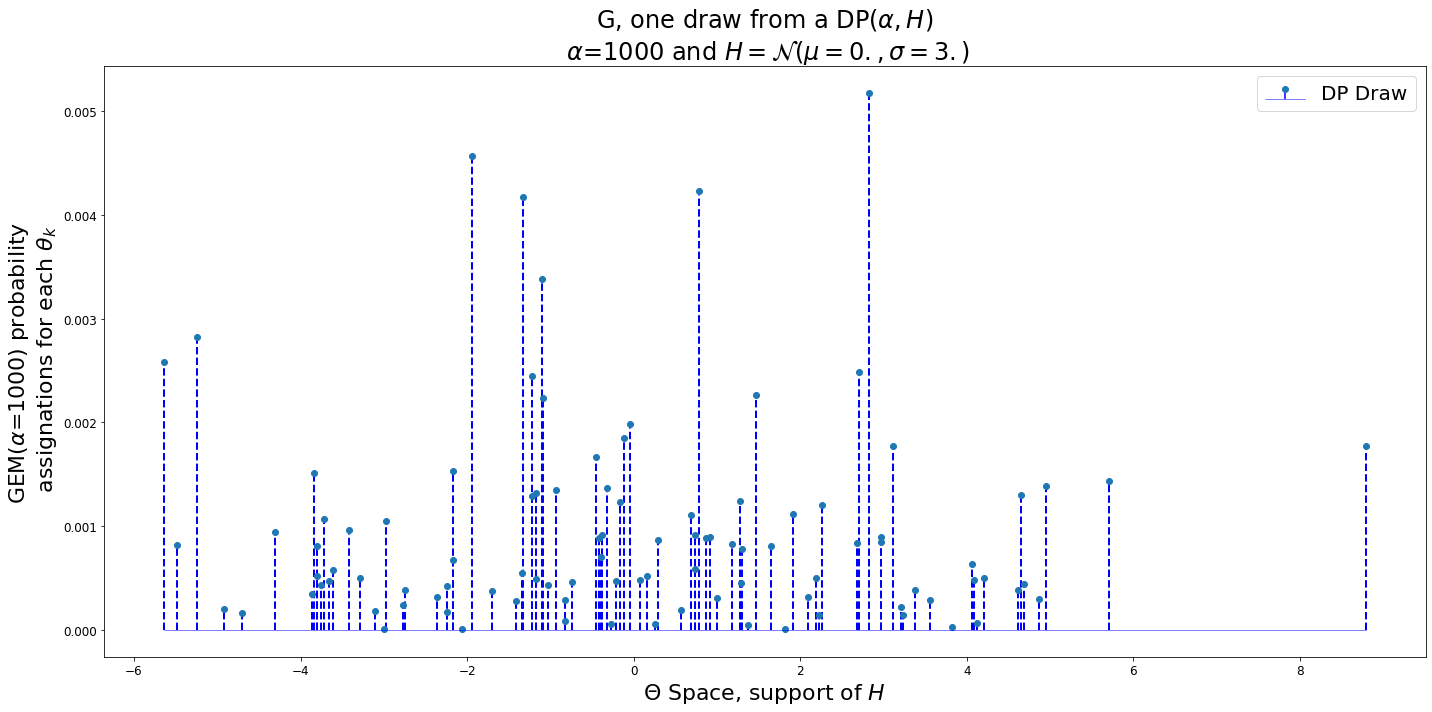

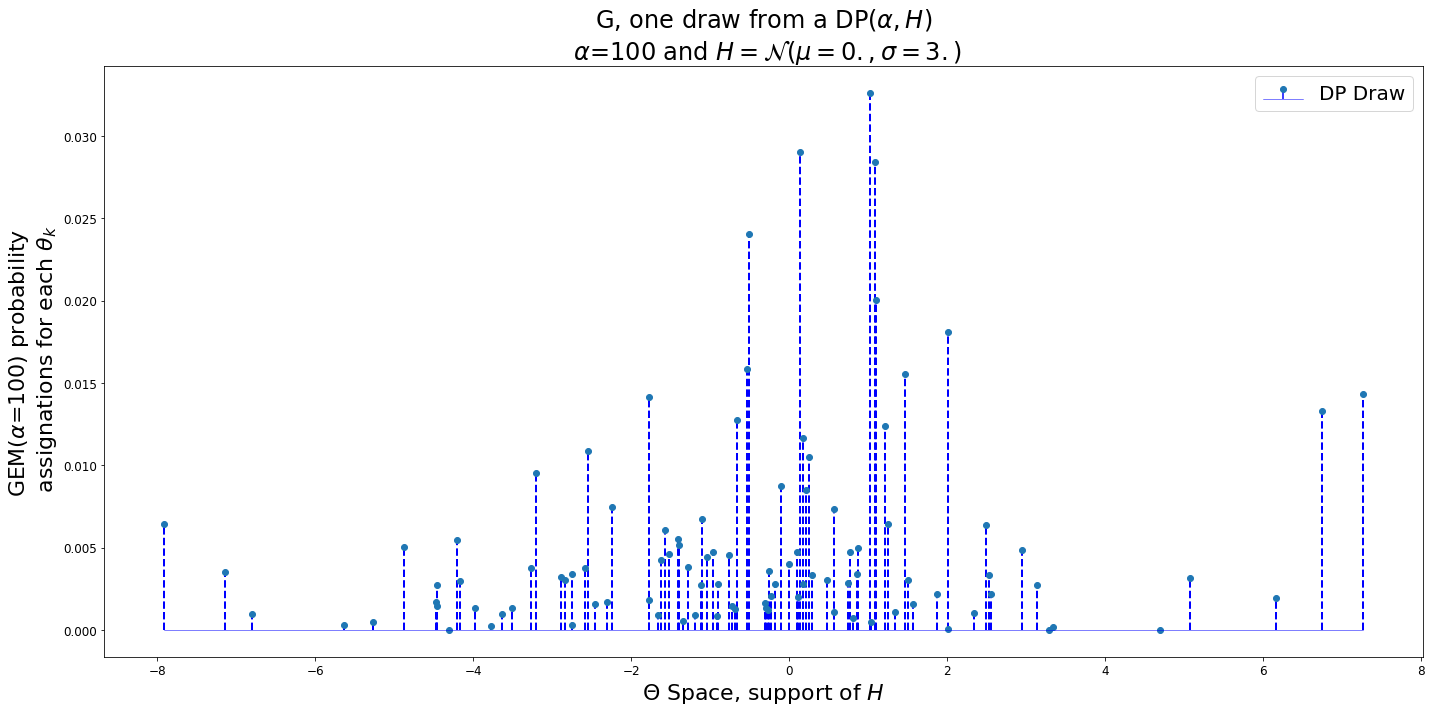

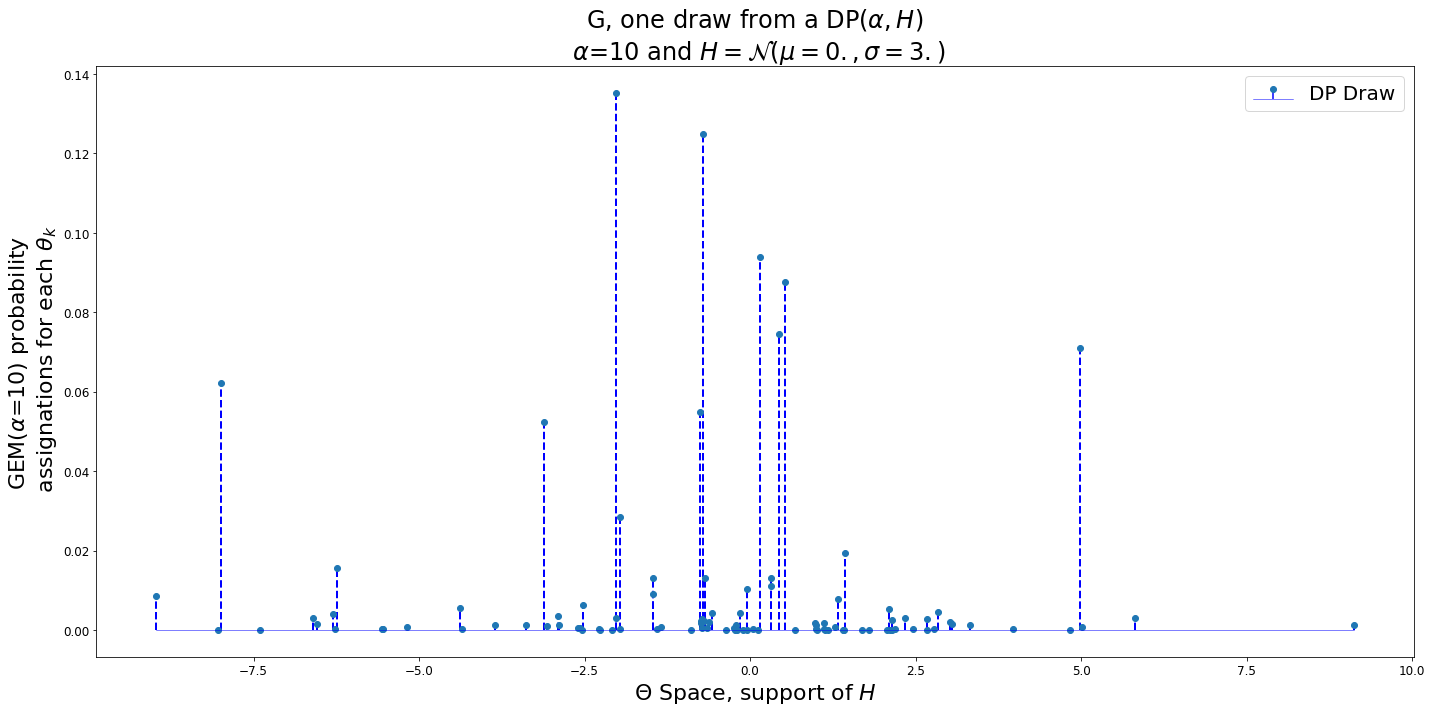

In [7]:
for alpha in dp_dict:
    dp_samples = dp_dict[alpha]
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)
    markeline, stemlines, baseline = ax.stem(dp_samples[0, :, 1], dp_samples[0, :, 0], '--', label='DP Draw', use_line_collection=True)
    plt.setp(stemlines, 'color', 'b', 'linewidth', 2)
    plt.setp(baseline, 'color', 'b', 'linewidth', 0.5)

    ax.set_title(r'G, one draw from a DP($\alpha, H$)'+'\n'+r' $\alpha$=%s and $H=\mathcal{N}(\mu=0.,\sigma=3.)$' % alpha, size=title_size)
    ax.set_xlabel(r'$\Theta$ Space, support of $H$', size=axis_size)
    ax.set_ylabel(r'GEM($\alpha$=%s) probability ' % alpha+'\n'+r' assignations for each $\theta_{k}$', size=axis_size)
    ax.tick_params(labelsize=axis_size-10)
    plt.tight_layout()
    plt.legend(prop={'size': legend_size})
    # plt.savefig('images/dp_draw/dp_draw_deltas_alpha_%s.png' % alpha, dpi=100)

In [8]:
markeline, stemlines, baseline = ax.stem(dp_samples[0, :, 1], dp_samples[0, :, 0], '--', label='DP Draw', use_line_collection=True)


In [9]:
G_0 = dp_samples[0, :, :]
np.sum(G_0[:,0])

0.9998724554064718

In [159]:
hdp_dict = dict()

G_0 = dp_samples[0, :, :]
G_0[:,0] /= np.sum(G_0[:,0])

alpha = 1000
hdp_large_alpha = hierarchical_dirichlet_process(alpha, G_0, k_trunc, num_samples, dim=2)
hdp_dict[alpha] = hdp_large_alpha

alpha = 100
hdp_medium_alpha = hierarchical_dirichlet_process(alpha, G_0, k_trunc, num_samples, dim=2)
hdp_dict[alpha] = hdp_medium_alpha

alpha = 10
hdp_small_alpha = hierarchical_dirichlet_process(alpha, G_0, k_trunc, num_samples, dim=2)
hdp_dict[alpha] = hdp_small_alpha


DP Constructed:
	 Number of samples: 1
	 Alpha: 10
	 Truncation value: 100
	 Bease measure: [[ 2.21517278e-01 -1.44865601e+00 -6.34736787e-01]
 [ 3.68696315e-01 -6.53653516e-01 -6.86865592e-01]
 [ 1.39960479e-04  1.52218432e-01 -5.64888342e-01]
 [ 1.16682847e-01  5.41585369e-01 -5.87495845e-02]
 [ 2.33545753e-01  6.66858528e-01 -1.40250589e+00]
 [ 1.23890371e-02 -1.37214188e+00 -1.64825752e-01]
 [ 3.94490846e-02  1.23534963e-02  2.44882670e-01]
 [ 5.70807891e-04 -3.66791549e-01 -1.98264211e-01]
 [ 5.71891632e-03  4.85235483e-01 -6.66190837e-01]
 [ 1.29000020e-03 -1.34846611e+00 -3.66641924e-01]]


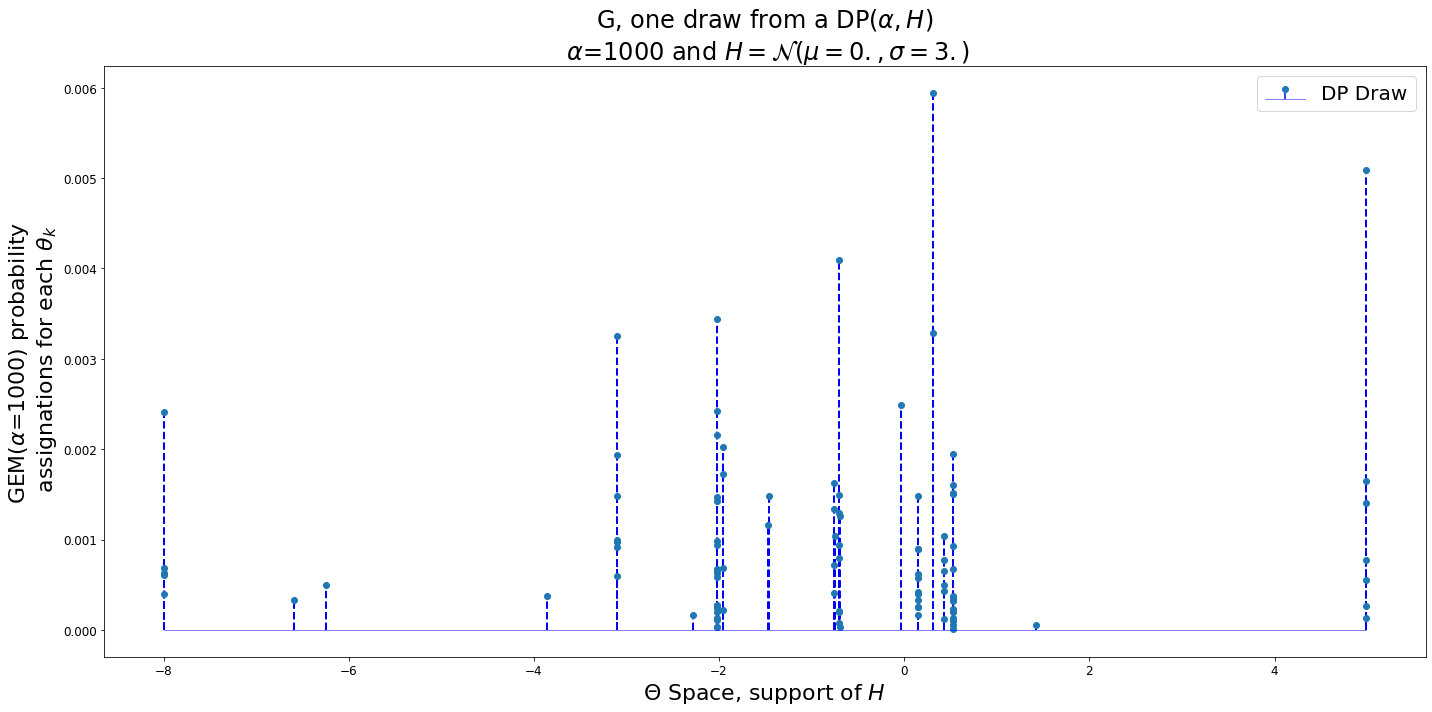

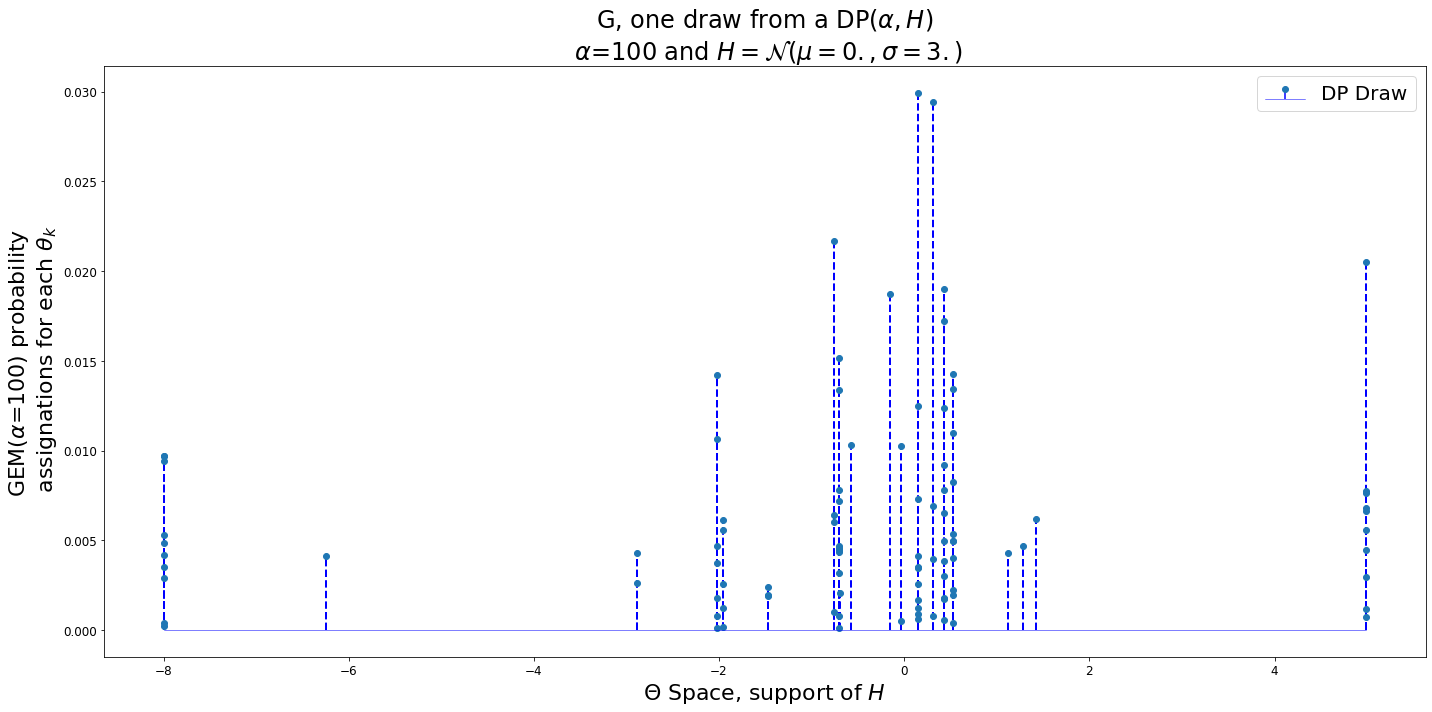

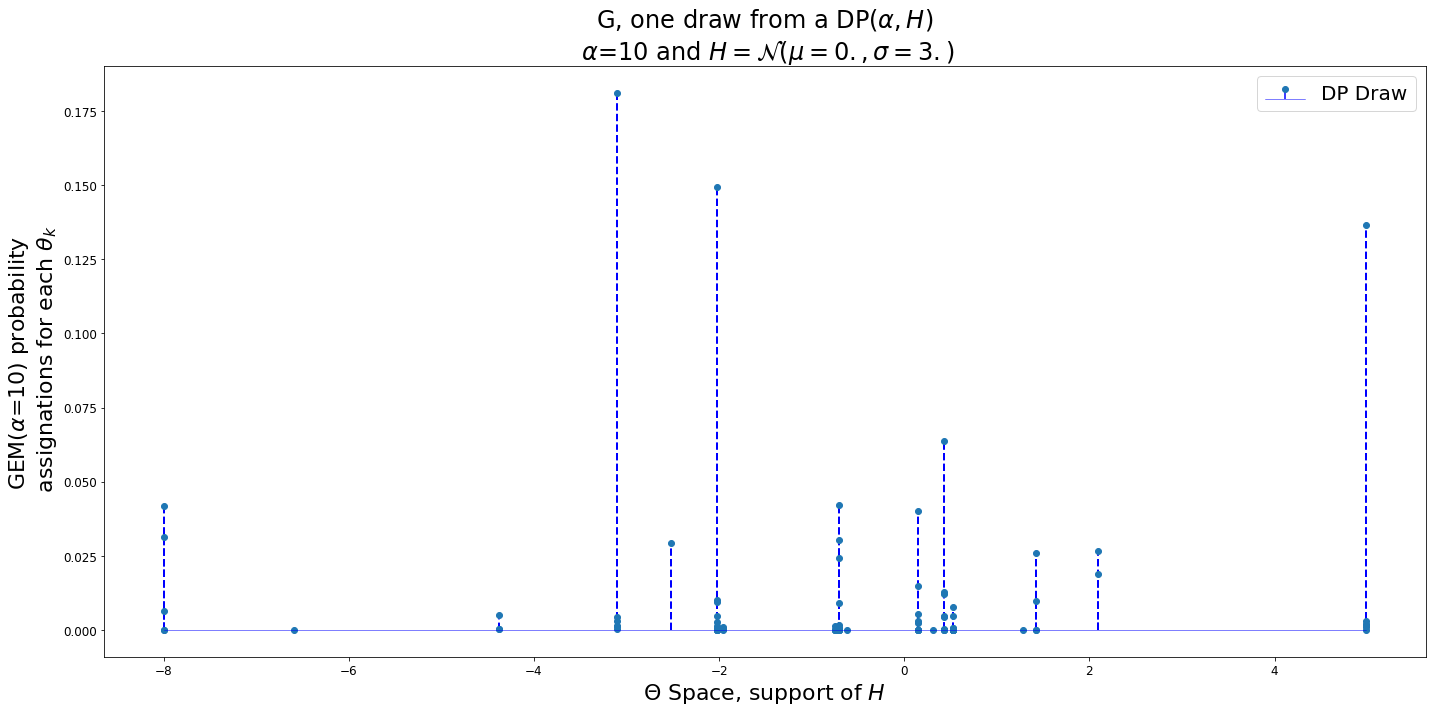

In [11]:
for alpha in hdp_dict:
    hdp_samples = hdp_dict[alpha]
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)
    markeline, stemlines, baseline = ax.stem(hdp_samples[0, :, 1], hdp_samples[0, :, 0], '--', label='DP Draw', use_line_collection=True)
    plt.setp(stemlines, 'color', 'b', 'linewidth', 2)
    plt.setp(baseline, 'color', 'b', 'linewidth', 0.5)

    ax.set_title(r'G, one draw from a DP($\alpha, H$)'+'\n'+r' $\alpha$=%s and $H=\mathcal{N}(\mu=0.,\sigma=3.)$' % alpha, size=title_size)
    ax.set_xlabel(r'$\Theta$ Space, support of $H$', size=axis_size)
    ax.set_ylabel(r'GEM($\alpha$=%s) probability ' % alpha+'\n'+r' assignations for each $\theta_{k}$', size=axis_size)
    ax.tick_params(labelsize=axis_size-10)
    plt.tight_layout()
    plt.legend(prop={'size': legend_size})
    # plt.savefig('images/dp_draw/dp_draw_deltas_alpha_%s.png' % alpha, dpi=100)

## Multivaraite Normal Mixture HDP

In [173]:
# multinorm_base = stats.multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])
mu = [0.5, -0.2, 0.9]
cov = [[2.0, 0.3, 0.1], [0.2, 0.5, 0.6], [0.3, 0.5, 0.88]]
multinorm_base = stats.multivariate_normal(mu, cov)

multinorm_base.rvs(1)

num_samples = 1
# base_function = stats.norm(loc=0., scale=3)
base_function = multinorm_base


# Keeping the same k_trunc for all DP samples, I do so to keep a closer approximation on the DP Draw plot, for the DP visualization over a finite set, we can use a lower 
# tructation number for the lower alphas since the dirichlet vector pi get closer to one with the first dimensions.

k_trunc = 20

alpha = 100
dim = len(mu)
dp_medium_alpha = dirichlet_process(alpha, base_function, k_trunc, num_samples, dim=dim)

print(dp_medium_alpha)

DP Constructed:
	 Number of samples: 1
	 Alpha: 100
	 Truncation value: 20
	 Bease measure: <scipy.stats._multivariate.multivariate_normal_frozen object at 0x1a16d54e10>
[[[ 3.95173470e-03  1.57751395e+00  7.56242922e-01  2.04137738e+00]
  [ 1.41342217e-02  2.35210829e-01 -2.10234950e-02  1.33737952e+00]
  [ 2.67054781e-03  7.32021171e-03  4.52826838e-01  2.72477162e+00]
  [ 3.22801791e-03 -2.89037481e+00 -9.71681444e-01  1.20294547e-01]
  [ 2.76653787e-03 -5.10316753e-01 -1.13783604e+00 -1.06479332e-02]
  [ 2.03284077e-04  3.24291813e+00  3.36602185e-01  1.11917211e+00]
  [ 2.06869477e-02 -7.28721967e-01 -7.48971366e-01  1.70261957e-01]
  [ 1.15440777e-02  3.89278509e-01 -7.30930356e-02  8.67236807e-01]
  [ 1.88416430e-03 -1.46276520e-01 -3.88270355e-01  8.75974865e-01]
  [ 3.04898097e-04  1.37771714e+00  3.06663654e-02  8.02702042e-01]
  [ 7.69747429e-03 -2.15087300e-01 -3.49440015e-01  8.76966189e-01]
  [ 2.77913071e-03  1.14421498e+00  1.13538322e+00  2.25027271e+00]
  [ 2.00419390

In [184]:
hdp_dict = dict()

G_0 = dp_medium_alpha[0, :, :]
G_0[:,0] /= np.sum(G_0[:,0])

k_trunc = 5

alpha = 100
hdp_medium_alpha = hierarchical_dirichlet_process(alpha, G_0, k_trunc, num_samples, dim=dim)

print(hdp_medium_alpha)

DP Constructed:
	 Number of samples: 1
	 Alpha: 100
	 Truncation value: 20
	 Bease measure: [[ 2.89427422e-02  1.57751395e+00  7.56242922e-01  2.04137738e+00]
 [ 1.03519888e-01  2.35210829e-01 -2.10234950e-02  1.33737952e+00]
 [ 1.95592525e-02  7.32021171e-03  4.52826838e-01  2.72477162e+00]
 [ 2.36421969e-02 -2.89037481e+00 -9.71681444e-01  1.20294547e-01]
 [ 2.02622895e-02 -5.10316753e-01 -1.13783604e+00 -1.06479332e-02]
 [ 1.48886478e-03  3.24291813e+00  3.36602185e-01  1.11917211e+00]
 [ 1.51512447e-01 -7.28721967e-01 -7.48971366e-01  1.70261957e-01]
 [ 8.45495179e-02  3.89278509e-01 -7.30930356e-02  8.67236807e-01]
 [ 1.37997325e-02 -1.46276520e-01 -3.88270355e-01  8.75974865e-01]
 [ 2.23309196e-03  1.37771714e+00  3.06663654e-02  8.02702042e-01]
 [ 5.63767639e-02 -2.15087300e-01 -3.49440015e-01  8.76966189e-01]
 [ 2.03545201e-02  1.14421498e+00  1.13538322e+00  2.25027271e+00]
 [ 1.46788364e-01 -2.94073250e+00 -3.05424504e-01  1.35752636e-01]
 [ 4.39176173e-02 -9.03281038e-02  6.

In [12]:
### Chinese Restaurant Process

In [13]:
def compute_cum_prob(counts, alpha):
    probs = np.array(counts)
    norm = probs.sum() + alpha
    probs = probs/norm
    probs = list(probs)
    probs.append(alpha/norm)
    
    cum = np.zeros(len(probs))
    for i in range(len(probs)):
        cum[i] = np.sum(probs[:i+1])        
    return cum

def new_customer(counts, alpha):
    unif = stats.uniform()
    u = unif.rvs(1)
    cum = compute_cum_prob(counts, alpha)
    for i, prob_c in enumerate(cum):
        if u < prob_c:
            if i == len(cum)-1:
                counts.append(1)
            else:
                counts[i] +=1
            break
    return counts

def chinese_restaurant_process(counts, alpha, n_cust):
    for j in range(n_cust):
        counts = new_customer(counts, alpha)
    return counts

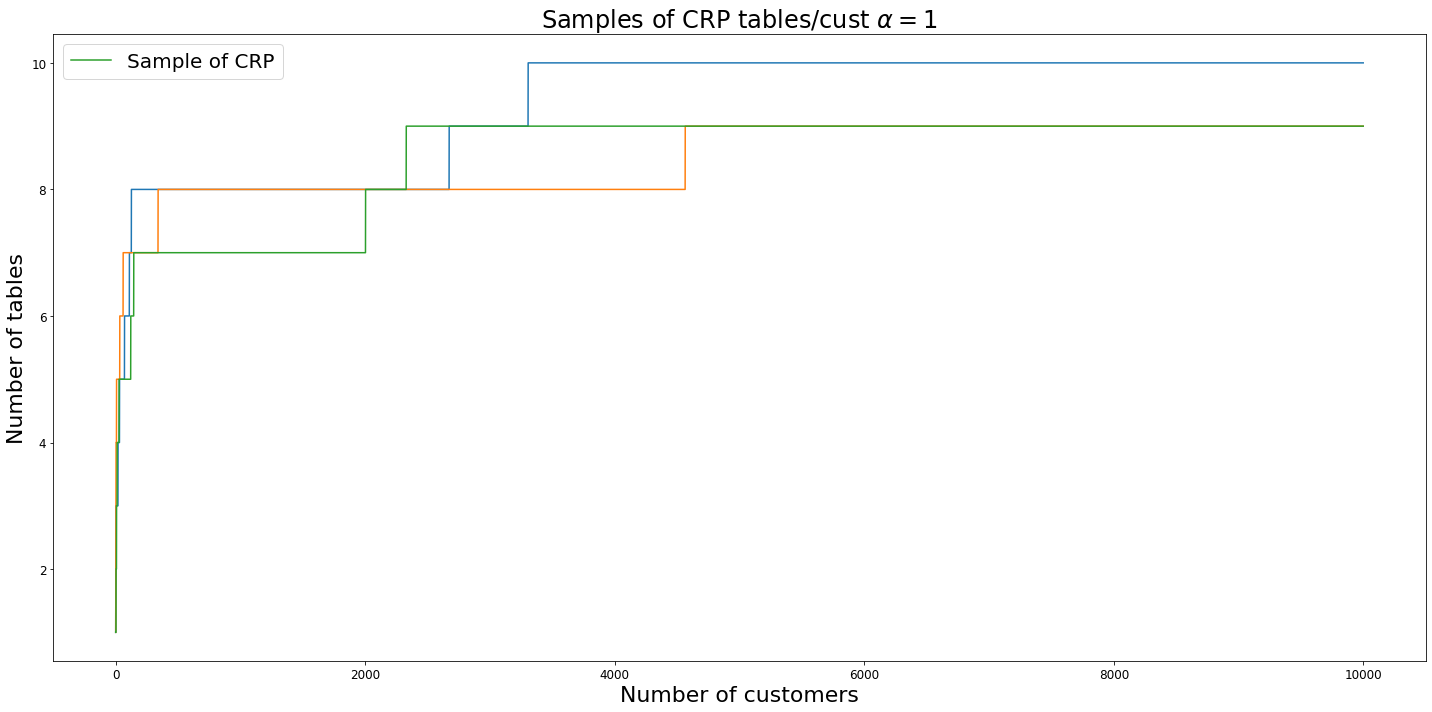

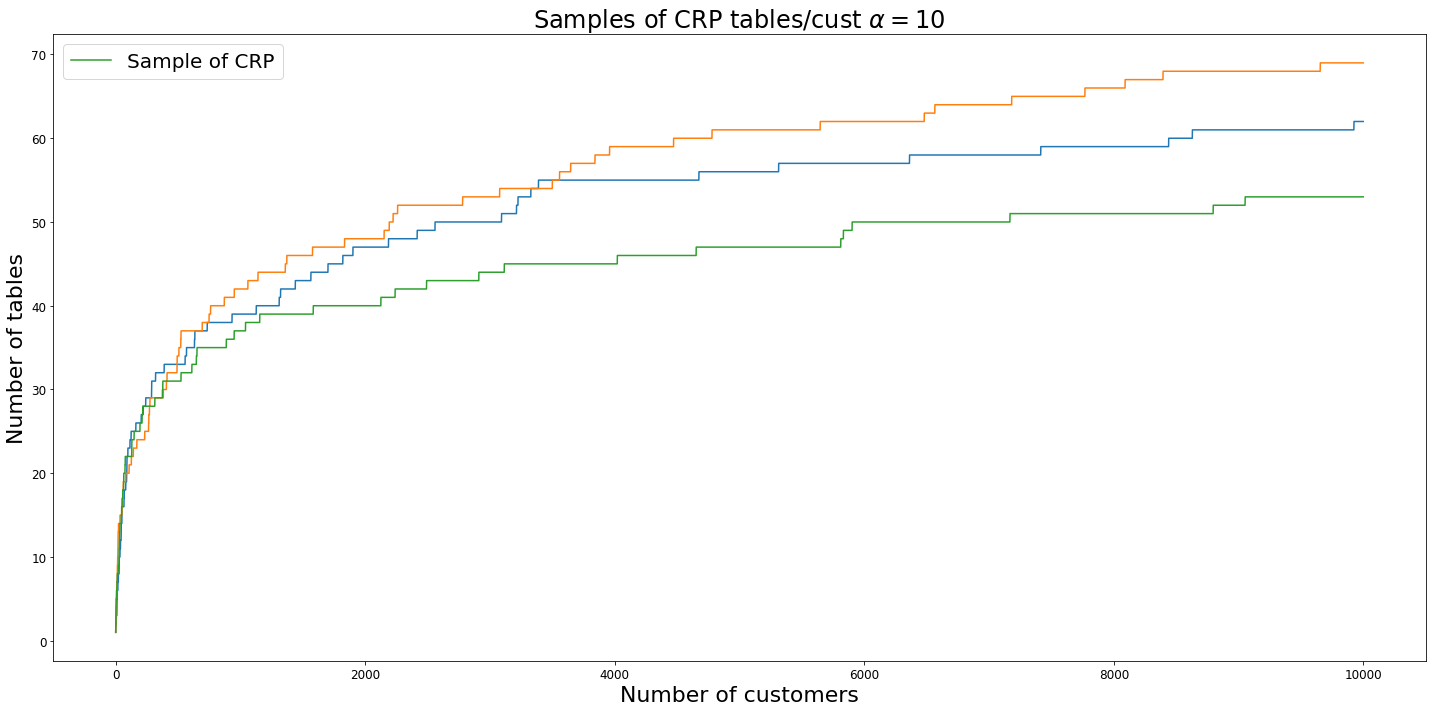

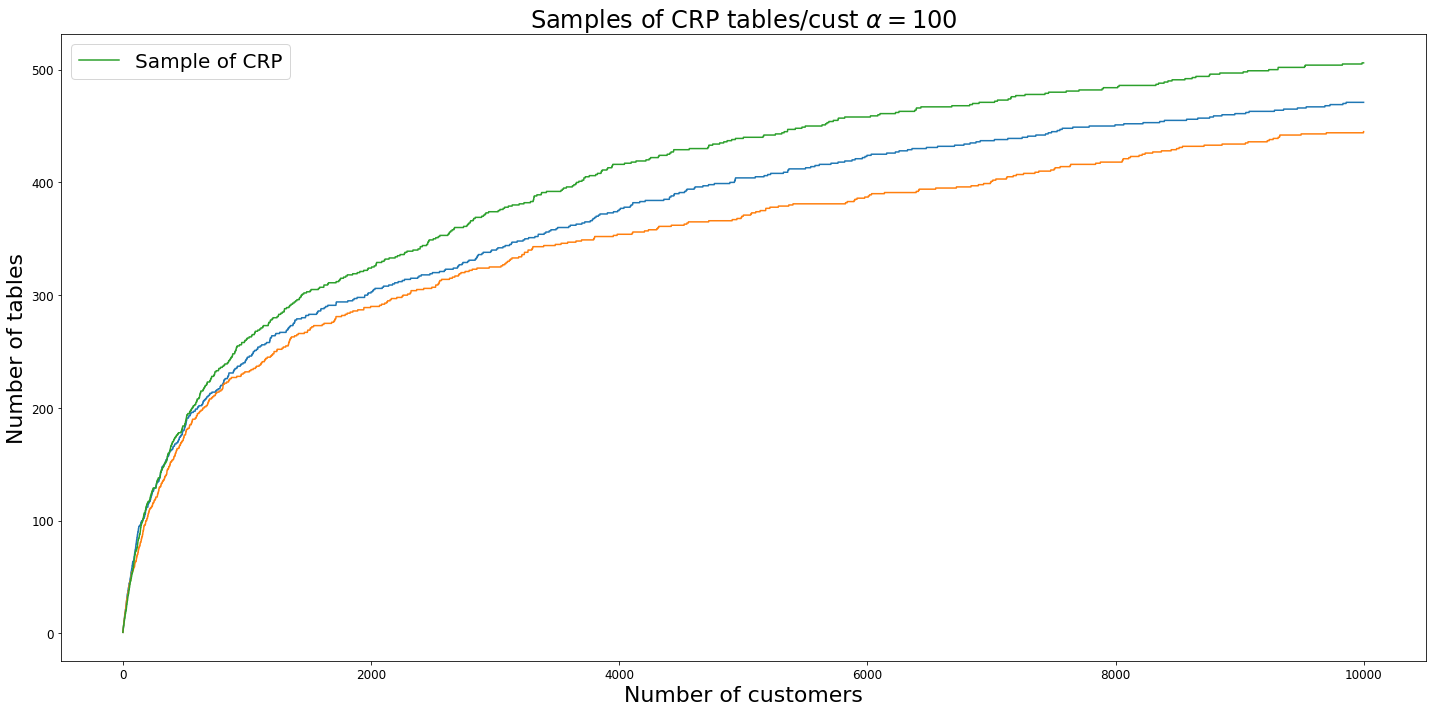

In [15]:
# Plot parameters
total_customers = 10000
samples_crp = 3

for alpha in [1, 10, 100]:
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)
    
    for j in range(samples_crp):
        counts = list()
        num_tables = list()
        for i in range(total_customers):
            counts = chinese_restaurant_process(counts, alpha, n_cust=1)
            num_tables.append(len(counts))
            print('Processed customer: Alpha %s Sample %s %s/%s' % (alpha, j, i+1, total_customers))
            clear_output(wait=True)
        if j != samples_crp-1:
            ax.plot(range(total_customers), num_tables)
    ax.plot(range(total_customers), num_tables, label='Sample of CRP')    
    ax.set_title(r'Samples of CRP tables/cust $\alpha=%s$' % alpha, size=title_size)
    ax.set_ylabel('Number of tables', size=axis_size)
    ax.set_xlabel('Number of customers', size=axis_size)
    ax.tick_params(labelsize=axis_size-10) 
    plt.legend(prop={'size': legend_size})
    plt.tight_layout()
#     plt.savefig('images/crp/chinese_restaurant_process_tables_alpha_%s.png' % alpha, dpi=100)

In [16]:
counts

[150,
 22,
 360,
 36,
 9,
 110,
 189,
 173,
 164,
 81,
 23,
 64,
 55,
 58,
 92,
 9,
 82,
 13,
 154,
 6,
 17,
 12,
 79,
 51,
 67,
 51,
 36,
 6,
 24,
 187,
 8,
 68,
 3,
 15,
 3,
 26,
 34,
 60,
 24,
 58,
 58,
 3,
 49,
 34,
 44,
 16,
 45,
 64,
 97,
 20,
 122,
 24,
 22,
 10,
 46,
 22,
 39,
 4,
 1,
 149,
 97,
 34,
 42,
 107,
 69,
 17,
 20,
 46,
 144,
 22,
 3,
 40,
 57,
 248,
 3,
 10,
 94,
 66,
 36,
 13,
 46,
 172,
 42,
 5,
 96,
 70,
 25,
 80,
 62,
 68,
 43,
 30,
 143,
 27,
 48,
 35,
 8,
 32,
 1,
 24,
 27,
 46,
 27,
 120,
 2,
 60,
 48,
 26,
 3,
 1,
 12,
 2,
 152,
 4,
 16,
 1,
 71,
 4,
 76,
 3,
 40,
 36,
 8,
 9,
 80,
 10,
 34,
 44,
 1,
 42,
 10,
 14,
 1,
 26,
 42,
 35,
 25,
 26,
 12,
 15,
 16,
 14,
 42,
 14,
 8,
 6,
 5,
 5,
 30,
 58,
 71,
 24,
 54,
 94,
 20,
 88,
 4,
 20,
 4,
 39,
 106,
 69,
 30,
 5,
 67,
 20,
 10,
 5,
 44,
 17,
 68,
 5,
 21,
 30,
 36,
 14,
 65,
 1,
 34,
 8,
 1,
 14,
 23,
 10,
 7,
 9,
 6,
 1,
 16,
 8,
 8,
 1,
 14,
 45,
 11,
 17,
 16,
 16,
 16,
 8,
 12,
 9,
 7,
 19,
 7,
 2,
 32

In [1]:
import gensim
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models import HdpModel

hdp = HdpModel(common_corpus, common_dictionary)

unseen_document = [(1, 3.), (2, 4)]
doc_hdp = hdp[unseen_document]

topic_info = hdp.print_topics(num_topics=20, num_words=10)

hdp.update([[(1, 2)], [(1, 1), (4, 5)]])

print('doc_hdp: ', doc_hdp, '\n')
print('topic_info: ', topic_info)

unable to import 'smart_open.gcs', disabling that module


doc_hdp:  [(0, 0.03194511543334235), (1, 0.023770720366415494), (2, 0.01771984163472844), (3, 0.013285932330155287), (77, 0.8741886387764158)] 

topic_info:  [(0, '0.210*eps + 0.151*system + 0.148*computer + 0.102*interface + 0.090*response + 0.065*minors + 0.061*user + 0.054*time + 0.049*human + 0.045*survey'), (1, '0.206*eps + 0.192*system + 0.167*interface + 0.132*human + 0.091*computer + 0.069*survey + 0.050*graph + 0.036*user + 0.021*response + 0.019*minors'), (2, '0.193*system + 0.164*graph + 0.123*survey + 0.108*trees + 0.102*computer + 0.076*time + 0.072*response + 0.046*interface + 0.035*minors + 0.032*eps'), (3, '0.206*human + 0.188*interface + 0.136*minors + 0.106*eps + 0.098*survey + 0.088*computer + 0.061*trees + 0.039*time + 0.028*response + 0.024*graph'), (4, '0.212*response + 0.171*user + 0.168*survey + 0.117*trees + 0.099*time + 0.080*human + 0.056*interface + 0.046*system + 0.026*minors + 0.010*computer'), (5, '0.176*human + 0.165*graph + 0.131*eps + 0.114*interface +